# Pairs Creation

1. Load Dataset
2. Uniform Sampling From Ultrafeedback
3. Pairs Creation
   1. Standard DPO pairs (Chosen =  highest overall_score, rejected = lowest overall_score)
   2. Diversity-aware DPO pairs (Chosen = highest avg. embedding distance above threshold, rejected = lowest avg. embedding distance above threshold)
   3. Diversity-aware DPO pairs (Chosen = highest LLM-as-judge diversity above threshold, rejected = lowest LLM-as-judge diversity above threshold) 
   

In [59]:
from datasets import load_from_disk
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from openai import OpenAI, RateLimitError
import numpy as np
from tqdm import tqdm
import time

from dotenv import load_dotenv
load_dotenv()

from sklearn.metrics.pairwise import cosine_distances

## Load Ultrafeedback Dataset

In [60]:
# ============================================================
# LOAD THE ULTRAFEEDBACK DATASET WITH CREATIVITY SCORES
# ============================================================

# Path to the dataset (update if different location)
dataset_path = "../data/final_lamini_informational_creative_dataset_uf"

# Load the dataset
dataset = load_from_disk(dataset_path)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total samples: {len(dataset):,}")
print(f"Number of features: {len(dataset.features)}")
print()

# ============================================================
# DISPLAY BASIC INFO
# ============================================================

print("=" * 80)
print("FEATURE NAMES")
print("=" * 80)
for i, feature in enumerate(dataset.features, 1):
    print(f"{i:2d}. {feature}")
print()

# ============================================================
# SHOW EXAMPLE SAMPLE
# ============================================================

print("=" * 80)
print("EXAMPLE SAMPLE (index 0)")
print("=" * 80)
example = dataset[0]

# Display instruction
print(f"\n📝 INSTRUCTION:")
print(f"   {example['instruction'][:200]}...")

# Display creativity classification
print(f"\n🎨 CREATIVITY CLASSIFICATION:")
print(f"   Label: {example['label']}")
print(f"   Factual score: {example['factual_score']:.4f}")
print(f"   Creative score: {example['creative_score']:.4f}")

# Display number of responses
print(f"\n🤖 RESPONSES:")
print(f"   Number of models: {example['num_models']}")

# Show each response with scores
for i in range(1, example['num_models'] + 1):
    answer_key = f'answer_{i}'
    fg_score_key = f'fine-grained_score_{i}'
    ov_score_key = f'overall_score_{i}'
    
    if answer_key in example and example[answer_key]:
        print(f"\n   Model {i}:")
        print(f"   - Answer: {example[answer_key][:100]}...")
        print(f"   - Fine-grained score: {example[fg_score_key]:.2f}")
        print(f"   - Overall score: {example[ov_score_key]:.2f}")

# ============================================================
# CONVERT TO PANDAS FOR ANALYSIS
# ============================================================

print("\n" + "=" * 80)
print("CONVERTING TO PANDAS")
print("=" * 80)

# Select key columns for analysis (drop nested structures)
columns_to_keep = [
    'instruction', 'label', 'factual_score', 'creative_score',
    'num_models', 'answer_1', 'answer_2', 'answer_3', 'answer_4',
    'fine-grained_score_1', 'fine-grained_score_2', 'fine-grained_score_3', 'fine-grained_score_4',
    'overall_score_1', 'overall_score_2', 'overall_score_3', 'overall_score_4'
]

df = dataset.to_pandas()[columns_to_keep]
print(f"Dataframe shape: {df.shape}")
print()

# ============================================================
# STATISTICS
# ============================================================

print("=" * 80)
print("CREATIVITY DISTRIBUTION")
print("=" * 80)
print(df['label'].value_counts())
print()
print(f"Mean creative score: {df['creative_score'].mean():.4f}")
print(f"Mean factual score: {df['factual_score'].mean():.4f}")
print()

print("=" * 80)
print("QUALITY SCORES STATISTICS")
print("=" * 80)
for i in range(1, 5):
    col = f'overall_score_{i}'
    if col in df.columns:
        print(f"Overall score {i}: mean={df[col].mean():.2f}, std={df[col].std():.2f}")

print("\n✅ Dataset loaded successfully!")
print(f"Use 'dataset' for HuggingFace Dataset object")
print(f"Use 'df' for Pandas DataFrame")

DATASET OVERVIEW
Total samples: 63,967
Number of features: 22

FEATURE NAMES
 1. source
 2. instruction
 3. models
 4. completions
 5. correct_answers
 6. incorrect_answers
 7. num_models
 8. answer_1
 9. fine-grained_score_1
10. overall_score_1
11. answer_2
12. fine-grained_score_2
13. overall_score_2
14. answer_3
15. fine-grained_score_3
16. overall_score_3
17. answer_4
18. fine-grained_score_4
19. overall_score_4
20. label
21. factual_score
22. creative_score

EXAMPLE SAMPLE (index 0)

📝 INSTRUCTION:
   Can you write a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea? Here's some starter code to help you out:
#include <iostream>
#include ...

🎨 CREATIVITY CLASSIFICATION:
   Label: factual
   Factual score: 0.6527
   Creative score: 0.3473

🤖 RESPONSES:
   Number of models: 4

   Model 1:
   - Answer: int main() {
    string country;
    // prompt user for input
    cout << "Enter the name of a count...
   - Fine-grained 

<Axes: xlabel='creative_score', ylabel='Count'>

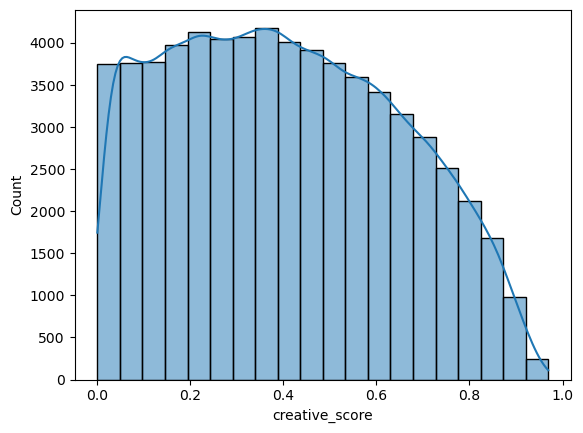

In [23]:
sns.histplot(df['creative_score'], bins=20, kde=True)

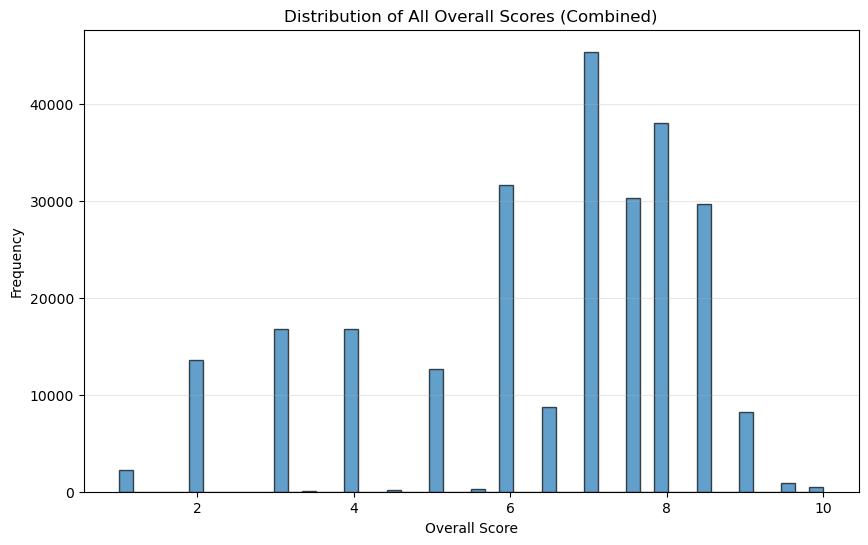

Total scores plotted: 255,864
Min score: 1.00
Max score: 10.00
Mean score: 6.44


In [24]:
all_scores = pd.concat([
    df['overall_score_1'],
    df['overall_score_2'],
    df['overall_score_3'],
    df['overall_score_4']
]).dropna()

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(all_scores, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.title('Distribution of All Overall Scores (Combined)')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Total scores plotted: {len(all_scores):,}")
print(f"Min score: {all_scores.min():.2f}")
print(f"Max score: {all_scores.max():.2f}")
print(f"Mean score: {all_scores.mean():.2f}")

## Uniform Sampling from Ultrafeedback

In [61]:
# ============================================================
# PARAMETERS - Adjust these to experiment
# ============================================================

TARGET_PAIRS = 10000          # Total pairs to generate
NUM_BINS = 5                 # Bins over creative_score
QUALITY_THRESH = 5       # Min overall_score to be valid
MIN_VALID_ANSWERS = 3     # Minimum high-quality answers required
MIN_DIVERSITY_GAP = 0.0      # Min |div(chosen) - div(rejected)|
EMBED_MODEL = "text-embedding-3-large"
LLM_JUDGE_MODEL = "Qwen/Qwen2.5-72B-Instruct-Turbo"  # Together API
RANDOM_SEED = 42
TEST_SIZE = 2000

TEST_PER_BIN = int(TEST_SIZE / NUM_BINS)

# Sampling buffer (sample extra to account for filtering)
SAMPLE_MULTIPLIER = 1.25     # Sample 1.5x target per bin

pairs_per_bin = TARGET_PAIRS // NUM_BINS
sample_per_bin = int(pairs_per_bin * SAMPLE_MULTIPLIER)

print(f"Target: {pairs_per_bin} pairs per bin")
print(f"Will sample: {sample_per_bin} rows per bin")
print(f"Test size: {TEST_PER_BIN} rows per bin")
print(f"Quality threshold: {QUALITY_THRESH}")

Target: 2000 pairs per bin
Will sample: 2500 rows per bin
Test size: 400 rows per bin
Quality threshold: 5


In [62]:
# ============================================================
# BIN PROMPTS BY CREATIVE SCORE
# ============================================================

import numpy as np
import pandas as pd

# Define bin edges
bin_edges = np.linspace(0.0, 1.0, NUM_BINS + 1)
print(f"Bin edges: {bin_edges}")

# Add alpha and alpha_bin columns
df['alpha'] = df['creative_score']
df['alpha_bin'] = pd.cut(
    df['alpha'], 
    bins=bin_edges, 
    labels=range(NUM_BINS), 
    include_lowest=True
)

# Check distribution
print("\nRows per bin:")
print(df['alpha_bin'].value_counts().sort_index())

Bin edges: [0.  0.2 0.4 0.6 0.8 1. ]

Rows per bin:
alpha_bin
0    15685
1    17023
2    15568
3    11778
4     3913
Name: count, dtype: int64


In [63]:
# ============================================================
# SAMPLE ROWS FROM EACH BIN
# ============================================================

sampled_rows = []
sampled_test_rows = []

for bin_idx in range(NUM_BINS):
    bin_df = df[df['alpha_bin'] == bin_idx]
    available = len(bin_df)
    
    if available < sample_per_bin + TEST_PER_BIN:
        print(f"⚠️  Bin {bin_idx}: Only {available} rows available (need {sample_per_bin})")
        sampled = bin_df
    else:
        sampled = bin_df.sample(n=sample_per_bin + TEST_PER_BIN, random_state=RANDOM_SEED + bin_idx)
    
    sampled_rows.append(sampled[:sample_per_bin])
    sampled_test_rows.append(sampled[sample_per_bin:])
    
    print(f"✓ Bin {bin_idx}: Sampled {len(sampled_rows[bin_idx])} train rows")
    print(f"✓ Bin {bin_idx}: Sampled {len(sampled_test_rows[bin_idx])} test rows")

# Combine all sampled rows
df_sampled = pd.concat(sampled_rows, ignore_index=True)
df_sampled_test = pd.concat(sampled_test_rows, ignore_index=True)
print(f"\n📊 Total train sampled: {len(df_sampled)} rows")
print(f"📊 Total test sampled: {len(df_sampled_test)} rows")

✓ Bin 0: Sampled 2500 train rows
✓ Bin 0: Sampled 400 test rows
✓ Bin 1: Sampled 2500 train rows
✓ Bin 1: Sampled 400 test rows
✓ Bin 2: Sampled 2500 train rows
✓ Bin 2: Sampled 400 test rows
✓ Bin 3: Sampled 2500 train rows
✓ Bin 3: Sampled 400 test rows
✓ Bin 4: Sampled 2500 train rows
✓ Bin 4: Sampled 400 test rows

📊 Total train sampled: 12500 rows
📊 Total test sampled: 2000 rows


## Pairs Creation


In [64]:
# ============================================================
# HELPER FUNCTIONS
# ============================================================

def is_creative_prompt(row):
    """Determine if prompt is creative or factual."""
    return row['creative_score'] >= row['factual_score']

def get_valid_candidates(row):
    """
    Returns: (valid_indices, answers, scores) or (None, None, None) if insufficient
    """
    answers = [row['answer_1'], row['answer_2'], row['answer_3'], row['answer_4']]
    scores = [
        row['overall_score_1'], 
        row['overall_score_2'], 
        row['overall_score_3'], 
        row['overall_score_4']
    ]
    
    valid_idxs = []
    for i in range(4):
        # Check: score exists, is above threshold, answer exists
        if (pd.notna(scores[i]) and 
            scores[i] >= QUALITY_THRESH and 
            pd.notna(answers[i]) and 
            str(answers[i]).strip() != ''):
            valid_idxs.append(i)
    
    if len(valid_idxs) < MIN_VALID_ANSWERS:
        return None, None, None
    
    return valid_idxs, answers, scores

print("✓ Helper functions defined")

✓ Helper functions defined


In [47]:
# ============================================================
# FILTER ROWS FOR ≥3 VALID RESPONSES
# ============================================================

rows_to_process = []
warning_count_3_valid = 0

for idx, row in df_sampled.iterrows():
    valid_idxs, answers, scores = get_valid_candidates(row)
    
    if valid_idxs is None:
        continue  # Skip: insufficient valid answers
    
    # Track 3/4 cases
    if len(valid_idxs) == 3:
        warning_count_3_valid += 1
    
    rows_to_process.append({
        'original_idx': idx,
        'row': row,
        'valid_idxs': valid_idxs,
        'answers': answers,
        'scores': scores,
        'num_valid': len(valid_idxs)
    })

print(f"✓ Rows passing quality filter: {len(rows_to_process)}/{len(df_sampled)}")
print(f"⚠️  Rows with only 3/4 valid answers: {warning_count_3_valid}")
print(f"✓ Rows with all 4/4 valid answers: {len(rows_to_process) - warning_count_3_valid}")
print(f"\n📊 Will embed {sum(r['num_valid'] for r in rows_to_process)} total answers")

✓ Rows passing quality filter: 10210/12500
⚠️  Rows with only 3/4 valid answers: 3176
✓ Rows with all 4/4 valid answers: 7034

📊 Will embed 37664 total answers


In [66]:
# ============================================================
# FILTER OUT PROMPTS WITH EMPTY/INVALID RESPONSES
# ============================================================

rows_after_empty_filter = []
filtered_out_empty = 0

for row_data in rows_to_process:
    answers = row_data['answers']
    
    # Check if ANY of the 4 responses are empty/None/whitespace
    has_empty = False
    for answer in answers:
        if not answer or (isinstance(answer, str) and answer.strip() == ""):
            has_empty = True
            break
    
    if has_empty:
        filtered_out_empty += 1
        continue
    
    rows_after_empty_filter.append(row_data)

print(f"✓ Rows after empty response filter: {len(rows_after_empty_filter)}/{len(rows_to_process)}")
print(f"🗑️  Filtered out {filtered_out_empty} prompts with empty responses")

# Update rows_to_process
rows_to_process = rows_after_empty_filter

✓ Rows after empty response filter: 10197/10210
🗑️  Filtered out 13 prompts with empty responses


In [69]:
# ============================================================
# SAVE FILTERED ROWS TO PICKLE FILE
# ============================================================

import pickle

output_pkl_path = "../scripts/filtered_rows.pkl"

with open(output_pkl_path, 'wb') as f:
    pickle.dump(rows_to_process, f)

print(f"✓ Saved {len(rows_to_process)} filtered rows to {output_pkl_path}")


✓ Saved 10197 filtered rows to ../scripts/filtered_rows.pkl


In [65]:
# ============================================================
# FILTER ROWS FOR ≥3 VALID RESPONSES
# ============================================================

rows_to_process = []
warning_count_3_valid = 0

for idx, row in df_sampled.iterrows():
    valid_idxs, answers, scores = get_valid_candidates(row)
    
    if valid_idxs is None:
        continue  # Skip: insufficient valid answers
    
    # Track 3/4 cases
    if len(valid_idxs) == 3:
        warning_count_3_valid += 1
    
    rows_to_process.append({
        'original_idx': idx,
        'row': row,
        'valid_idxs': valid_idxs,
        'answers': answers,
        'scores': scores,
        'num_valid': len(valid_idxs)
    })

print(f"✓ Rows passing quality filter: {len(rows_to_process)}/{len(df_sampled)}")
print(f"⚠️  Rows with only 3/4 valid answers: {warning_count_3_valid}")
print(f"✓ Rows with all 4/4 valid answers: {len(rows_to_process) - warning_count_3_valid}")
print(f"\n📊 Will embed {sum(r['num_valid'] for r in rows_to_process)} total answers")

✓ Rows passing quality filter: 10210/12500
⚠️  Rows with only 3/4 valid answers: 3176
✓ Rows with all 4/4 valid answers: 7034

📊 Will embed 37664 total answers


In [50]:
# ============================================================
# FILTER OUT PROMPTS WITH EMPTY/INVALID RESPONSES
# ============================================================

rows_after_empty_filter = []
filtered_out_empty = 0

for row_data in rows_to_process:
    answers = row_data['answers']
    
    # Check if ANY of the 4 responses are empty/None/whitespace
    has_empty = False
    for answer in answers:
        if not answer or (isinstance(answer, str) and answer.strip() == ""):
            has_empty = True
            break
    
    if has_empty:
        filtered_out_empty += 1
        continue
    
    rows_after_empty_filter.append(row_data)

print(f"✓ Rows after empty response filter: {len(rows_after_empty_filter)}/{len(rows_to_process)}")
print(f"🗑️  Filtered out {filtered_out_empty} prompts with empty responses")

# Update rows_to_process
rows_to_process = rows_after_empty_filter

✓ Rows after empty response filter: 10197/10210
🗑️  Filtered out 13 prompts with empty responses


In [51]:
# ============================================================
# COMPUTE EMBEDDINGS IN BATCHES (ALL 4 RESPONSES)
# ============================================================
client = OpenAI()

def get_embeddings_batch(texts, model=EMBED_MODEL, batch_size=50):
    """Get embeddings in batches with retry logic for rate limits."""
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i:i+batch_size]
        
        # Retry with exponential backoff
        max_retries = 5
        for attempt in range(max_retries):
            try:
                response = client.embeddings.create(
                    input=batch,
                    model=model
                )
                batch_embeddings = [item.embedding for item in response.data]
                all_embeddings.extend(batch_embeddings)
                break
            except RateLimitError as e:
                if attempt == max_retries - 1:
                    raise
                wait_time = 2 ** attempt
                print(f"\n⏳ Rate limited. Waiting {wait_time}s...")
                time.sleep(wait_time)
        
        time.sleep(0.2)  # Small delay between batches
    
    return np.array(all_embeddings)

# Collect all texts to embed (ALL 4 responses per prompt)
all_texts = []
text_to_row_mapping = []

for row_idx, row_data in enumerate(rows_to_process):
    # Embed ALL 4 responses (indices 0-3)
    for answer_idx in range(4):
        answer_text = row_data['answers'][answer_idx]
        all_texts.append(str(answer_text))
        text_to_row_mapping.append((row_idx, answer_idx))

print(f"📝 Prepared {len(all_texts)} texts for embedding ({len(rows_to_process)} prompts × 4 responses)")
print(f"💰 Estimated cost: ~${len(all_texts) * 200 * 0.13 / 1_000_000:.2f}")

# Get embeddings
embeddings = get_embeddings_batch(all_texts)
print(f"✓ Got embeddings with shape: {embeddings.shape}")

# ============================================================
# SAVE EMBEDDINGS CACHE FOR LATER d_pair COMPUTATION
# ============================================================

embedding_cache = {}

for (row_idx, answer_idx), embedding in zip(text_to_row_mapping, embeddings):
    row_data = rows_to_process[row_idx]
    prompt_text = row_data['row']['instruction']
    answer_text = row_data['answers'][answer_idx]
    
    # Use hash as key to save memory
    key = (hash(prompt_text), hash(answer_text))
    embedding_cache[key] = embedding

print(f"💾 Cached {len(embedding_cache)} embeddings")

# Save cache to disk
import pickle
with open('embedding_cache.pkl', 'wb') as f:
    pickle.dump(embedding_cache, f)

print("✅ Saved embedding_cache.pkl")

📝 Prepared 40788 texts for embedding (10197 prompts × 4 responses)
💰 Estimated cost: ~$1.06


Embedding:  79%|███████▉  | 644/816 [10:32<02:59,  1.04s/it]


⏳ Rate limited. Waiting 1s...


Embedding:  84%|████████▎ | 683/816 [11:19<02:48,  1.27s/it]


⏳ Rate limited. Waiting 1s...


Embedding: 100%|██████████| 816/816 [14:09<00:00,  1.04s/it]


✓ Got embeddings with shape: (40788, 3072)
💾 Cached 40529 embeddings
✅ Saved embedding_cache.pkl


In [49]:
# ============================================================
# COMPUTE EMBEDDINGS IN BATCHES
# ============================================================
client = OpenAI()

def get_embeddings_batch(texts, model=EMBED_MODEL, batch_size=50):
    """Get embeddings in batches with retry logic for rate limits."""
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i:i+batch_size]
        
        # Retry with exponential backoff
        max_retries = 5
        for attempt in range(max_retries):
            try:
                response = client.embeddings.create(
                    input=batch,
                    model=model
                )
                batch_embeddings = [item.embedding for item in response.data]
                all_embeddings.extend(batch_embeddings)
                break
            except RateLimitError as e:
                if attempt == max_retries - 1:
                    raise
                wait_time = 2 ** attempt
                print(f"\n⏳ Rate limited. Waiting {wait_time}s...")
                time.sleep(wait_time)
        
        time.sleep(0.2)  # Small delay between batches
    
    return np.array(all_embeddings)

# Collect all texts to embed
all_texts = []
text_to_row_mapping = []

for row_idx, row_data in enumerate(rows_to_process):
    for valid_idx in row_data['valid_idxs']:
        answer_text = row_data['answers'][valid_idx]
        all_texts.append(str(answer_text))
        text_to_row_mapping.append((row_idx, valid_idx))

print(f"📝 Prepared {len(all_texts)} texts for embedding")
print(f"💰 Estimated cost: ~${len(all_texts) * 200 * 0.13 / 1_000_000:.2f}")

# Get embeddings
embeddings = get_embeddings_batch(all_texts)
print(f"✓ Got embeddings with shape: {embeddings.shape}")

# Create a mapping: (prompt_text, answer_text) -> embedding
embedding_cache = {}

for (row_idx, valid_idx), embedding in zip(text_to_row_mapping, embeddings):
    row_data = rows_to_process[row_idx]
    prompt_text = row_data['row']['instruction']
    answer_text = row_data['answers'][valid_idx]
    
    # Use hash as key to save memory
    key = (hash(prompt_text), hash(answer_text))
    embedding_cache[key] = embedding

print(f"💾 Cached {len(embedding_cache)} embeddings")

# Save cache to disk
import pickle
with open('embedding_cache.pkl', 'wb') as f:
    pickle.dump(embedding_cache, f)

print("✅ Saved embedding_cache.pkl")

📝 Prepared 37664 texts for embedding
💰 Estimated cost: ~$0.98


Embedding:  79%|███████▉  | 594/754 [10:19<02:30,  1.06it/s]


⏳ Rate limited. Waiting 1s...


Embedding:  81%|████████  | 612/754 [10:41<02:19,  1.02it/s]


⏳ Rate limited. Waiting 1s...


Embedding:  89%|████████▉ | 673/754 [12:04<01:08,  1.18it/s]


⏳ Rate limited. Waiting 1s...


Embedding: 100%|██████████| 754/754 [13:50<00:00,  1.10s/it]


✓ Got embeddings with shape: (37664, 3072)
💾 Cached 37414 embeddings
✅ Saved embedding_cache.pkl


In [52]:
# ============================================================
# COMPUTE DIVERSITY SCORES PER ROW (ONLY VALID RESPONSES)
# ============================================================

from sklearn.metrics.pairwise import cosine_distances

def compute_diversity_scores(embeddings_subset):
    """
    Given embeddings for one prompt's valid answers,
    return diversity score for each (mean distance to others).
    """
    if len(embeddings_subset) < 2:
        return [0.0]
    
    # Cosine distances
    dist_matrix = cosine_distances(embeddings_subset)
    
    # Diversity = mean distance to all others
    diversity_scores = []
    for i in range(len(embeddings_subset)):
        # Exclude self (distance = 0)
        other_distances = [dist_matrix[i][j] for j in range(len(embeddings_subset)) if i != j]
        diversity_scores.append(np.mean(other_distances))
    
    return diversity_scores

# Assign diversity scores back to rows
for row_idx, row_data in enumerate(rows_to_process):
    valid_idxs = row_data['valid_idxs']
    
    # Extract embeddings for ONLY valid responses
    # Since embeddings array has [row0_ans0, row0_ans1, row0_ans2, row0_ans3, row1_ans0, ...]
    # We need to map: row_idx * 4 + answer_idx
    valid_embeddings = []
    for valid_idx in valid_idxs:
        embedding_position = row_idx * 4 + valid_idx
        valid_embeddings.append(embeddings[embedding_position])
    
    valid_embeddings = np.array(valid_embeddings)
    diversity_scores = compute_diversity_scores(valid_embeddings)
    
    row_data['diversity_scores'] = diversity_scores
    row_data['valid_embeddings'] = valid_embeddings  # Store for later
    
print(f"✓ Computed diversity scores for {len(rows_to_process)} rows")
print(f"Example diversity scores (first row): {rows_to_process[0]['diversity_scores']}")

✓ Computed diversity scores for 10197 rows
Example diversity scores (first row): [np.float64(0.44229202318252747), np.float64(0.30665431706230495), np.float64(0.3080246035126648)]


In [53]:
# ============================================================
# APPLY MIN_DIVERSITY_GAP FILTER (FINAL FILTERED SET)
# ============================================================

filtered_rows = []
skipped_diversity_gap = 0

for row_data in rows_to_process:
    diversity_scores = row_data['diversity_scores']
    
    # Check diversity gap
    if len(diversity_scores) >= 2:
        div_gap = max(diversity_scores) - min(diversity_scores)
        if MIN_DIVERSITY_GAP > 0 and div_gap < MIN_DIVERSITY_GAP:
            skipped_diversity_gap += 1
            continue
    
    filtered_rows.append(row_data)

print(f"✓ Final filtered prompts: {len(filtered_rows)}")
print(f"🚫 Skipped due to diversity gap: {skipped_diversity_gap}")
print(f"\n📊 This is the COMMON SET for all 3 datasets")

✓ Final filtered prompts: 10197
🚫 Skipped due to diversity gap: 0

📊 This is the COMMON SET for all 3 datasets


In [54]:
# ============================================================
# DATASET 1: EMBEDDING-BASED DIVERSITY PAIRS
# ============================================================

dataset1_pairs = []

for row_data in filtered_rows:
    row = row_data['row']
    valid_idxs = row_data['valid_idxs']
    answers = row_data['answers']
    scores = row_data['scores']
    diversity_scores = row_data['diversity_scores']
    
    # Determine prompt type
    is_creative = is_creative_prompt(row)
    
    # Choose based on diversity
    if is_creative:
        chosen_local_idx = np.argmax(diversity_scores)
        rejected_local_idx = np.argmin(diversity_scores)
    else:
        chosen_local_idx = np.argmin(diversity_scores)
        rejected_local_idx = np.argmax(diversity_scores)
    
    # Map back to original indices
    chosen_idx = valid_idxs[chosen_local_idx]
    rejected_idx = valid_idxs[rejected_local_idx]
    
    # Build pair
    pair = {
        'input': row['instruction'],
        'chosen': answers[chosen_idx],
        'rejected': answers[rejected_idx],
        'prompt_label': 'creative' if is_creative else 'factual',
        'factual_score': row['factual_score'],
        'creative_score': row['creative_score'],
        'alpha_bin': row['alpha_bin'],
        'chosen_overall_score': scores[chosen_idx],
        'rejected_overall_score': scores[rejected_idx],
        'chosen_diversity': diversity_scores[chosen_local_idx],
        'rejected_diversity': diversity_scores[rejected_local_idx],
        'num_valid_answers': len(valid_idxs),
        'dataset_type': 'embedding_diversity'
    }
    
    dataset1_pairs.append(pair)

print(f"✅ Dataset 1 (Embedding Diversity): {len(dataset1_pairs)} pairs")

# Check distribution
dataset1_df = pd.DataFrame(dataset1_pairs)
print("\n📊 Pairs per bin:")
print(dataset1_df['alpha_bin'].value_counts().sort_index())
print("\n📊 Pairs per prompt type:")
print(dataset1_df['prompt_label'].value_counts())

✅ Dataset 1 (Embedding Diversity): 10197 pairs

📊 Pairs per bin:
alpha_bin
0    1908
1    1936
2    1946
3    2150
4    2257
Name: count, dtype: int64

📊 Pairs per prompt type:
prompt_label
creative    5395
factual     4802
Name: count, dtype: int64


In [55]:
# ============================================================
# DATASET 2: QUALITY-BASED (STANDARD DPO) PAIRS
# ============================================================

dataset2_pairs = []

for row_data in filtered_rows:
    row = row_data['row']
    valid_idxs = row_data['valid_idxs']
    answers = row_data['answers']
    scores = row_data['scores']
    
    # Chosen: best valid score
    valid_scores = [scores[i] for i in valid_idxs]
    best_local_idx = np.argmax(valid_scores)
    chosen_idx = valid_idxs[best_local_idx]
    
    # Rejected: worst score among ALL 4 responses
    worst_overall_idx = np.argmin(scores)
    
    # Build pair
    pair = {
        'input': row['instruction'],
        'chosen': answers[chosen_idx],
        'rejected': answers[worst_overall_idx],
        'prompt_label': 'creative' if is_creative_prompt(row) else 'factual',
        'factual_score': row['factual_score'],
        'creative_score': row['creative_score'],
        'alpha_bin': row['alpha_bin'],
        'chosen_overall_score': scores[chosen_idx],
        'rejected_overall_score': scores[worst_overall_idx],
        'num_valid_answers': len(valid_idxs),
        'dataset_type': 'quality_based'
    }
    
    dataset2_pairs.append(pair)

print(f"✅ Dataset 2 (Quality-Based): {len(dataset2_pairs)} pairs")

# Check distribution
dataset2_df = pd.DataFrame(dataset2_pairs)
print("\n📊 Pairs per bin:")
print(dataset2_df['alpha_bin'].value_counts().sort_index())
print("\n📊 Pairs per prompt type:")
print(dataset2_df['prompt_label'].value_counts())

✅ Dataset 2 (Quality-Based): 10197 pairs

📊 Pairs per bin:
alpha_bin
0    1908
1    1936
2    1946
3    2150
4    2257
Name: count, dtype: int64

📊 Pairs per prompt type:
prompt_label
creative    5395
factual     4802
Name: count, dtype: int64


In [56]:
# ============================================================
# SAVE ALL 3 DATASETS
# ============================================================

# Save as parquet
dataset1_df.to_parquet("dataset1_embedding_diversity.parquet", index=False)
dataset2_df.to_parquet("dataset2_quality_based.parquet", index=False)
# dataset3_df.to_parquet("dataset3_llm_judge_diversity.parquet", index=False)

print("✅ SAVED ALL DATASETS:")
print(f"  1. dataset1_embedding_diversity.parquet ({len(dataset1_df)} pairs)")
print(f"  2. dataset2_quality_based.parquet ({len(dataset2_df)} pairs)")
# print(f"  3. dataset3_llm_judge_diversity.parquet ({len(dataset3_df)} pairs)")

print("\n📊 FINAL SUMMARY:")
print(f"  Common filtered prompts: {len(filtered_rows)}")
print(f"  All datasets use the same {len(filtered_rows)} prompts")
print(f"  Dataset 1 columns: {list(dataset1_df.columns)}")
print(f"  Dataset 2 columns: {list(dataset2_df.columns)}")
# print(f"  Dataset 3 columns: {list(dataset3_df.columns)}")

df_sampled_test.to_parquet("test_ultrafeedback.parquet", index=False)

✅ SAVED ALL DATASETS:
  1. dataset1_embedding_diversity.parquet (10197 pairs)
  2. dataset2_quality_based.parquet (10197 pairs)

📊 FINAL SUMMARY:
  Common filtered prompts: 10197
  All datasets use the same 10197 prompts
  Dataset 1 columns: ['input', 'chosen', 'rejected', 'prompt_label', 'factual_score', 'creative_score', 'alpha_bin', 'chosen_overall_score', 'rejected_overall_score', 'chosen_diversity', 'rejected_diversity', 'num_valid_answers', 'dataset_type']
  Dataset 2 columns: ['input', 'chosen', 'rejected', 'prompt_label', 'factual_score', 'creative_score', 'alpha_bin', 'chosen_overall_score', 'rejected_overall_score', 'num_valid_answers', 'dataset_type']


In [57]:
# ============================================================
# SYNC DATASETS - KEEP ONLY ROWS VALID ACROSS ALL DATASETS
# ============================================================
# Ensures all datasets have the same valid rows (same indices)

import pandas as pd
import numpy as np

# ============================================================
# CONFIGURATION: List datasets to sync
# ============================================================
DATASETS = [
    "dataset1_embedding_diversity.parquet",
    "dataset2_quality_based.parquet",
    # "dataset3_llm_judge_diversity.parquet",  # Uncomment when ready
]

# ============================================================
# Helper function
# ============================================================
def is_valid_text(text):
    """Check if text is valid (not None, not empty, not just whitespace)."""
    if text is None:
        return False
    if isinstance(text, float) and pd.isna(text):
        return False
    text_str = str(text).strip()
    if len(text_str) == 0:
        return False
    return True

# ============================================================
# Load all datasets and find valid indices
# ============================================================
print(f"Loading {len(DATASETS)} datasets...")
dataframes = {}
valid_indices_per_dataset = {}

for dataset_file in DATASETS:
    # Load
    df = pd.read_parquet(f"../scripts/{dataset_file}")
    dataframes[dataset_file] = df
    print(f"\n📂 {dataset_file}")
    print(f"   → Rows: {len(df)}")
    
    # Find valid indices (both chosen AND rejected must be valid)
    valid_chosen = df['chosen'].apply(is_valid_text)
    valid_rejected = df['rejected'].apply(is_valid_text)
    valid_indices = valid_chosen & valid_rejected
    
    # Store as set of indices
    valid_indices_per_dataset[dataset_file] = set(df[valid_indices].index.tolist())
    
    print(f"   → Valid rows: {len(valid_indices_per_dataset[dataset_file])}")
    print(f"   → Invalid rows: {len(df) - len(valid_indices_per_dataset[dataset_file])}")

# ============================================================
# Find intersection of valid indices across all datasets
# ============================================================
print(f"\n{'='*70}")
print(f"FINDING INTERSECTION OF VALID INDICES...")
print(f"{'='*70}")

# Start with first dataset's valid indices
common_valid_indices = valid_indices_per_dataset[DATASETS[0]].copy()
print(f"\nStarting with {DATASETS[0]}: {len(common_valid_indices)} valid indices")

# Intersect with each subsequent dataset
for dataset_file in DATASETS[1:]:
    before = len(common_valid_indices)
    common_valid_indices = common_valid_indices.intersection(valid_indices_per_dataset[dataset_file])
    after = len(common_valid_indices)
    print(f"After intersecting with {dataset_file}: {after} indices (removed {before - after})")

print(f"\n✅ Common valid indices across all datasets: {len(common_valid_indices)}")

# Convert to sorted list
common_valid_indices = sorted(list(common_valid_indices))

# ============================================================
# Filter all datasets to keep only common valid indices
# ============================================================
print(f"\n{'='*70}")
print(f"FILTERING DATASETS TO COMMON VALID INDICES...")
print(f"{'='*70}")

for dataset_file in DATASETS:
    df_original = dataframes[dataset_file]
    df_filtered = df_original.loc[common_valid_indices].reset_index(drop=True)
    
    print(f"\n📂 {dataset_file}")
    print(f"   → Original: {len(df_original)} rows")
    print(f"   → Filtered: {len(df_filtered)} rows")
    print(f"   → Removed:  {len(df_original) - len(df_filtered)} rows")
    
    # Backup original
    if len(df_original) != len(df_filtered):
        backup_path = f"../scripts/{dataset_file}.backup"
        df_original.to_parquet(backup_path, index=False)
        print(f"   💾 Backed up to: {dataset_file}.backup")
        
        # Save filtered
        df_filtered.to_parquet(f"../scripts/{dataset_file}", index=False)
        print(f"   💾 Saved filtered dataset")
    else:
        print(f"   ✅ No changes needed")

# ============================================================
# Verify all datasets now have same size
# ============================================================
print(f"\n{'='*70}")
print(f"VERIFICATION")
print(f"{'='*70}")

sizes = []
for dataset_file in DATASETS:
    df = pd.read_parquet(f"../scripts/{dataset_file}")
    sizes.append(len(df))
    print(f"{dataset_file}: {len(df)} rows")

if len(set(sizes)) == 1:
    print(f"\n✅ SUCCESS! All datasets synchronized with {sizes[0]} rows")
else:
    print(f"\n⚠️  WARNING: Datasets have different sizes: {sizes}")

print(f"\n{'='*70}\n")

Loading 2 datasets...

📂 dataset1_embedding_diversity.parquet
   → Rows: 10197
   → Valid rows: 10197
   → Invalid rows: 0

📂 dataset2_quality_based.parquet
   → Rows: 10197
   → Valid rows: 10197
   → Invalid rows: 0

FINDING INTERSECTION OF VALID INDICES...

Starting with dataset1_embedding_diversity.parquet: 10197 valid indices
After intersecting with dataset2_quality_based.parquet: 10197 indices (removed 0)

✅ Common valid indices across all datasets: 10197

FILTERING DATASETS TO COMMON VALID INDICES...

📂 dataset1_embedding_diversity.parquet
   → Original: 10197 rows
   → Filtered: 10197 rows
   → Removed:  0 rows
   ✅ No changes needed

📂 dataset2_quality_based.parquet
   → Original: 10197 rows
   → Filtered: 10197 rows
   → Removed:  0 rows
   ✅ No changes needed

VERIFICATION
dataset1_embedding_diversity.parquet: 10197 rows
dataset2_quality_based.parquet: 10197 rows

✅ SUCCESS! All datasets synchronized with 10197 rows




In [58]:
# ============================================================
# ADD d_pair TO SYNCED DATASETS USING CACHED EMBEDDINGS
# ============================================================
import pickle
from sklearn.metrics.pairwise import cosine_distances

# Load embedding cache
with open('embedding_cache.pkl', 'rb') as f:
    embedding_cache = pickle.load(f)

print(f"✅ Loaded {len(embedding_cache)} cached embeddings")

# Process each dataset
DATASETS = [
    "dataset1_embedding_diversity.parquet",
    "dataset2_quality_based.parquet",
    # "dataset3_llm_judge_diversity.parquet",  # Uncomment when ready
]

for dataset_file in DATASETS:
    print(f"\n{'='*70}")
    print(f"Processing {dataset_file}")
    print(f"{'='*70}")
    
    # Load synced dataset
    df = pd.read_parquet(f"../scripts/{dataset_file}")
    
    # Compute d_pair for each row
    d_pairs = []
    missing_count = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Computing d_pair"):
        prompt = row['input']
        chosen = row['chosen']
        rejected = row['rejected']
        
        # Look up embeddings from cache
        chosen_key = (hash(prompt), hash(chosen))
        rejected_key = (hash(prompt), hash(rejected))
        
        if chosen_key in embedding_cache and rejected_key in embedding_cache:
            chosen_emb = embedding_cache[chosen_key]
            rejected_emb = embedding_cache[rejected_key]
            
            # Compute cosine distance
            d_pair = cosine_distances([chosen_emb], [rejected_emb])[0, 0]
            d_pairs.append(d_pair)
        else:
            # Fallback: use placeholder (shouldn't happen if sync worked)
            missing_count += 1
            d_pairs.append(np.nan)
    
    if missing_count > 0:
        print(f"⚠️  Warning: {missing_count} embeddings not found in cache")
    
    # Add d_pair column
    df['d_pair'] = d_pairs
    
    # Save
    df.to_parquet(f"../scripts/{dataset_file}", index=False)
    
    print(f"✅ Added d_pair to {dataset_file}")
    print(f"   Mean: {np.nanmean(d_pairs):.4f}")
    print(f"   Std:  {np.nanstd(d_pairs):.4f}")

print(f"\n{'='*70}")
print("✅ ALL DATASETS NOW HAVE d_pair COLUMN")
print(f"{'='*70}")

✅ Loaded 40529 cached embeddings

Processing dataset1_embedding_diversity.parquet


Computing d_pair: 100%|██████████| 10197/10197 [00:01<00:00, 6950.60it/s]


✅ Added d_pair to dataset1_embedding_diversity.parquet
   Mean: 0.3057
   Std:  0.1825

Processing dataset2_quality_based.parquet


Computing d_pair: 100%|██████████| 10197/10197 [00:01<00:00, 7135.80it/s]

✅ Added d_pair to dataset2_quality_based.parquet
   Mean: 0.3370
   Std:  0.2172

✅ ALL DATASETS NOW HAVE d_pair COLUMN
